# 📈 Prediksi Harga Saham UNVR Menggunakan Prophet

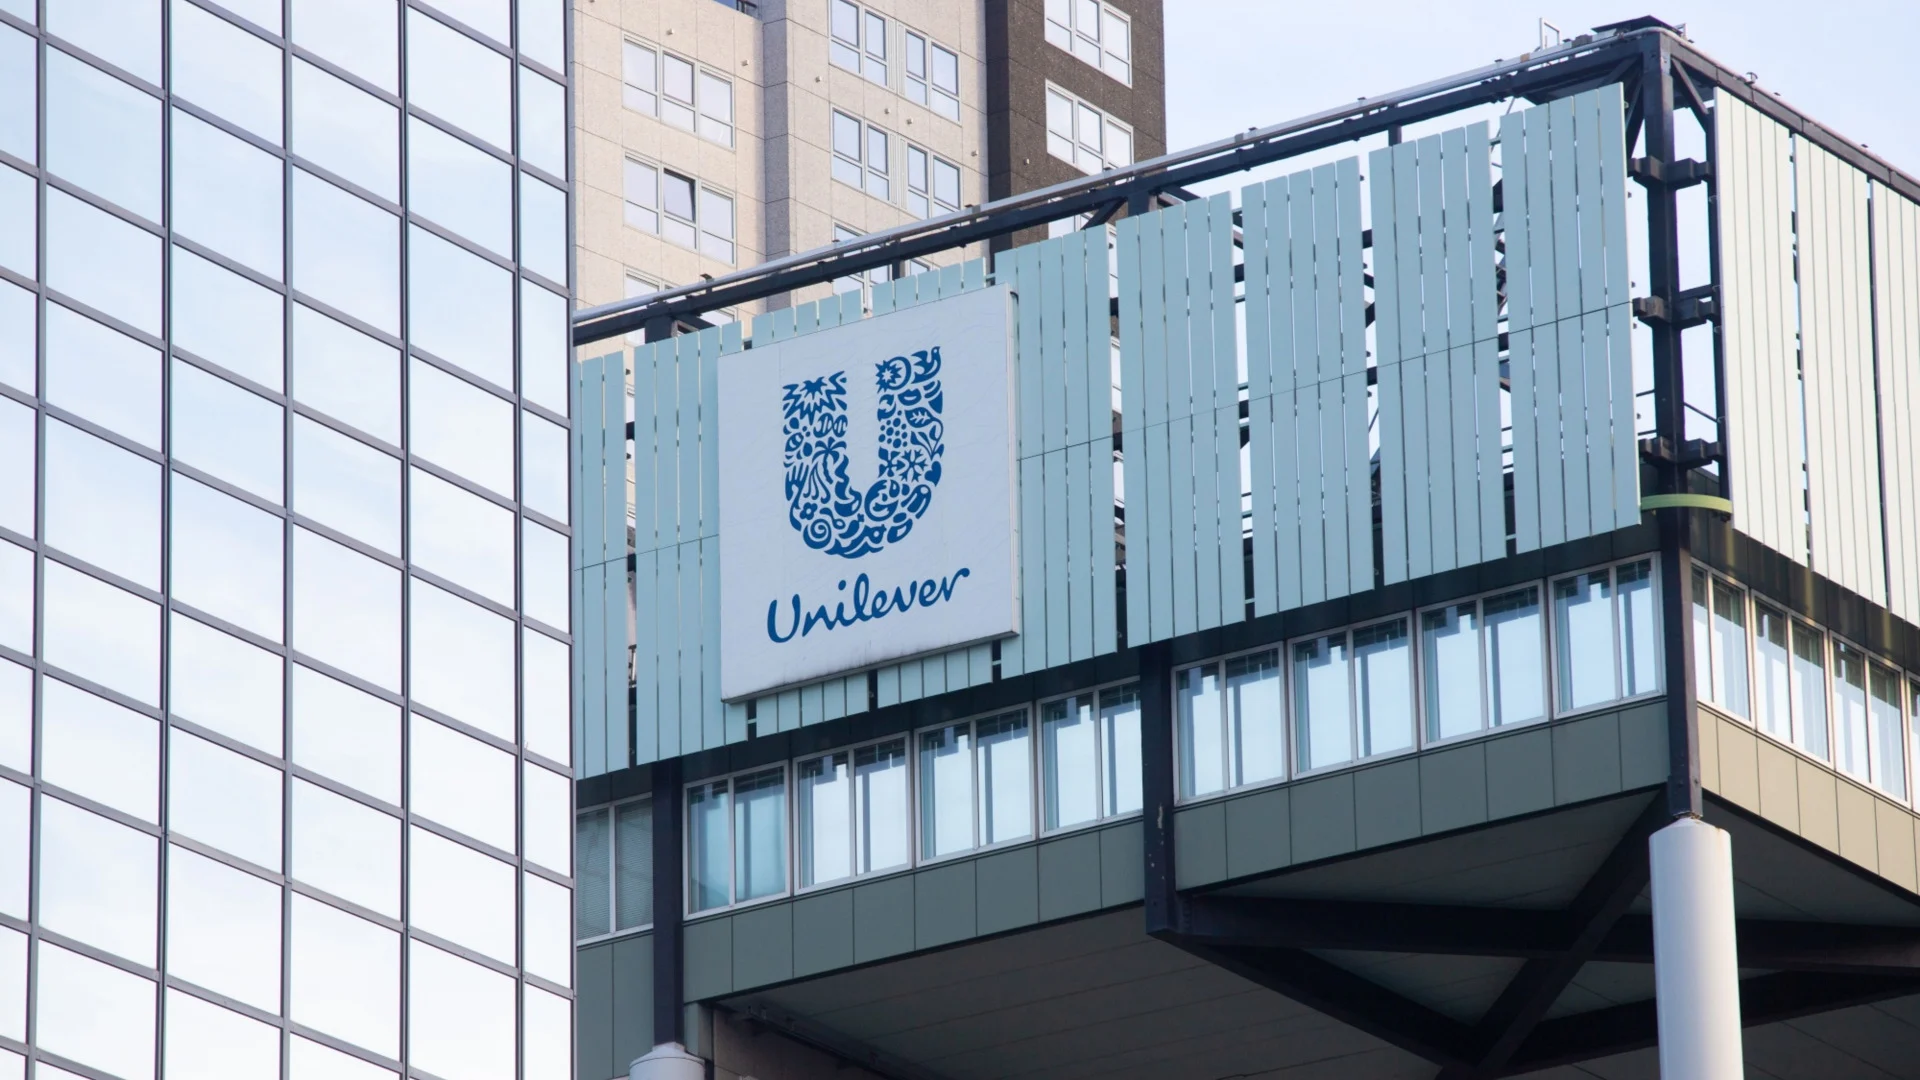

**Data Scientist:**
- Ahmad Faik Setiawan
- Yora Okta Aviani Rahardjo
- Meriani Alexandra
- Ditya Ayu Anjani
- Mauritz Labaro Lumban Gaol
- Kaila Amira Azzahra

### 🧠 Latar Belakang
PT Unilever Indonesia Tbk (UNVR) merupakan salah satu perusahaan consumer goods terbesar di Indonesia. Harga saham UNVR sering menjadi perhatian investor karena fluktuasinya mencerminkan kinerja perusahaan serta sentimen pasar. Dengan perkembangan data science dan machine learning, model prediksi berbasis data historis dapat membantu investor dalam mengambil keputusan investasi yang lebih tepat waktu dan berbasis bukti.

### ❓ Permasalahan
Bagaimana memprediksi harga saham UNVR secara akurat menggunakan model Prophet dengan data historis dari tahun 2013 hingga 2017, serta melakukan proyeksi harga saham untuk 12 bulan ke depan (2018)?

### 🎯 Tujuan
- Melatih model prediksi berbasis Prophet menggunakan data historis harga saham UNVR.
- Melakukan tuning parameter untuk meningkatkan akurasi.
- Mengevaluasi performa model pada tahun 2017.
- Memprediksi harga saham selama 12 bulan ke depan (2018).
- Memberikan insight dan rekomendasi strategis untuk investor.

# Pemahaman Data

In [1]:
# ======================
# IMPORT MODUL
# ======================
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# ======================
# LOAD DATA
# ======================
print("⏳ Loading data...")
df = pd.read_csv("Data Historis UNVR (2).csv", thousands=".")
df = df.rename(columns={"Tanggal": "ds", "Terakhir": "y"})
df["ds"] = pd.to_datetime(df["ds"], format="%d/%m/%Y")
df = df.sort_values("ds").reset_index(drop=True)

# Filter data hanya antara 2013-01-01 sampai 2017-12-31
start_date = "2013-01-01"
end_date = "2017-12-31"
df = df[(df["ds"] >= start_date) & (df["ds"] <= end_date)].reset_index(drop=True)
df.head()

⏳ Loading data...


,ds,y,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2013-01-01,4410,4180,4630,4180,"277,86M","5,76%"
1,2013-02-01,4570,4370,4660,4330,"214,45M","3,63%"
2,2013-03-01,4560,4600,4620,4340,"193,78M","-0,22%"
3,2013-04-01,5250,4480,5250,4430,"216,09M","15,13%"
4,2013-05-01,6100,5000,6900,4960,"241,08M","16,19%"


# Pengolahan Data
Membersihkan kolom volume dan perubahan persentase agar bisa digunakan sebagai fitur regresor tambahan di Prophet.

In [3]:
# ======================
# PREPROCESING
# ======================
# Fungsi untuk bersihkan kolom Vol.
def parse_volume(x):
    if isinstance(x, str):
        x = x.strip()
        if x.endswith("M"):
            return float(x[:-1].replace(",", "").replace(".", "")) * 1_000_000
        elif x.endswith("K"):
            return float(x[:-1].replace(",", "").replace(".", "")) * 1_000
        else:
            # Hilangkan titik dan koma untuk angka biasa
            return float(x.replace(",", "").replace(".", ""))
    return x


df["Vol."] = df["Vol."].apply(parse_volume)

# Bersihkan kolom Perubahan%
df["Perubahan%"] = (
    df["Perubahan%"]
    .astype(str)
    .str.replace("%", "")
    .str.replace(",", ".")
    .astype(float)
)

# Pilih fitur tambahan yang mau dipakai sebagai regressor
feature_cols = ["Pembukaan", "Tertinggi", "Terendah", "Vol.", "Perubahan%"]

# Buang row yang ada NaN di fitur atau target
df = df.dropna(subset=["y"] + feature_cols)

# Visualisasi Tren/Pola Pergerakan Harga Saham

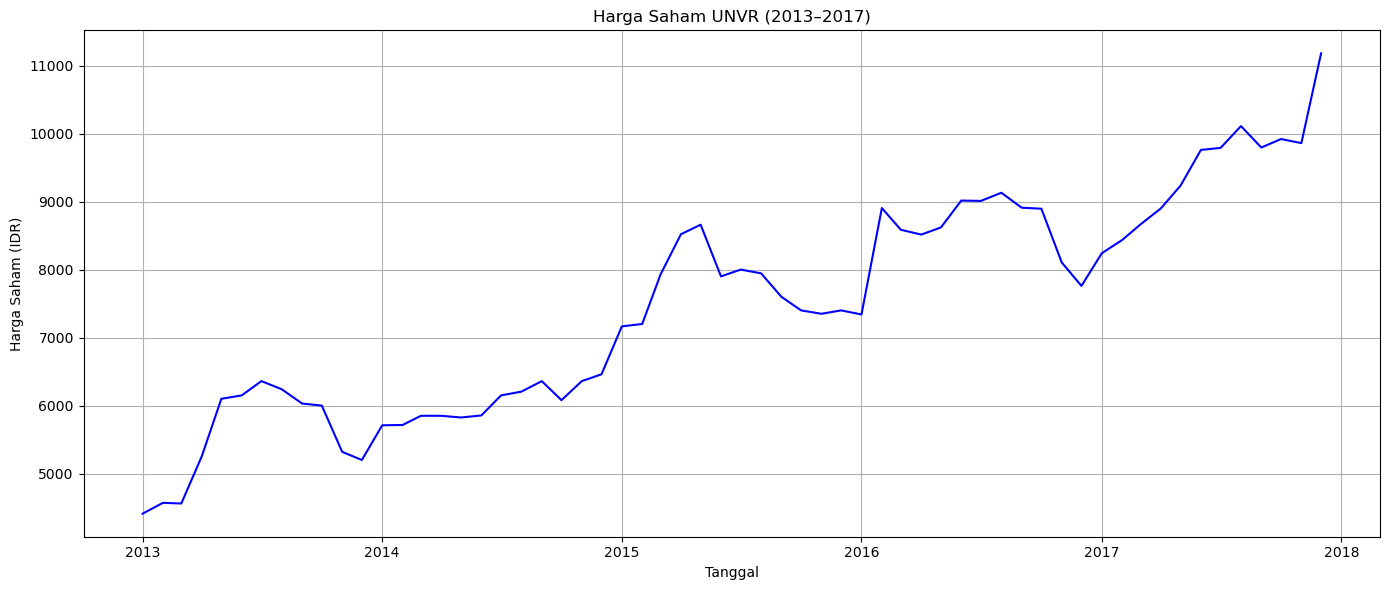

In [4]:
# ======================
# VISUALISASI DATA
# ======================
plt.figure(figsize=(14, 6))
plt.plot(df["ds"], df["y"], color="blue")
plt.title("Harga Saham UNVR (2013–2017)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham (IDR)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Ringkasan Saham UNVR
display(df["ds"].min(), df["ds"].max())
display(df["y"].describe())

Timestamp('2013-01-01 00:00:00')

Timestamp('2017-12-01 00:00:00')

count       60.000000
mean      7472.666667
std       1621.385541
min       4410.000000
25%       6095.000000
50%       7500.000000
75%       8722.500000
max      11180.000000
Name: y, dtype: float64

## Insights 
📈 1. Tren Umum: Kenaikan Harga Saham
- Secara umum, tren harga saham UNVR cenderung naik dari 2013 hingga 2017.
- Harga saham naik dari sekitar 4.500 IDR pada awal 2013 menjadi lebih dari 11.000 IDR pada akhir 2017.
- Ini menunjukkan bahwa UNVR memiliki pertumbuhan nilai yang cukup stabil dan kuat selama periode ini.

📉 2. Periode Konsolidasi dan Koreksi Harga

- Sumber: https://www.investopedia.com/terms/t/taper-tantrum.asp
- 2013: Terjadi kenaikan tajam di awal 2013 hingga pertengahan 2013, lalu sempat menurun pada periode akhir 2013. Ini bisa mencerminkan volatilitas pasar atau faktor eksternal seperti kondisi ekonomi makro dan perubahan kebijakan The Fed untuk mengurangi laju pembelian obligasi pemerintah, guna mengurangi jumlah uang yang disalurkan ke dalam perekonomian (taper tantrum). 
- 2015–2016: Harga kembali naik tajam hingga awal 2016, diikuti oleh sedikit penurunan dan konsolidasi di pertengahan 2016.

🔍 3. Lonjakan Tajam di Akhir 2017
Pada kuartal akhir 2017, terlihat lonjakan harga yang sangat signifikan, melewati angka 11.000 IDR. Ini disebabkan oleh:
- Sumber: https://www.bareksa.com/berita/berita-ekonomi-terkini/2017-10-03/unvr-meroket-2925-persen-sepanjang-2017-ini-analisa-kinerja-dan-saham-unilever?
- Rilis laporan keuangan yang positif.
- UNVR mampu menjaga tingkat profitabilitasnya dengan sangat baik.
- Sentimen investor terhadap saham-saham consumer goods.

# Dekomposisi Saham UNVR

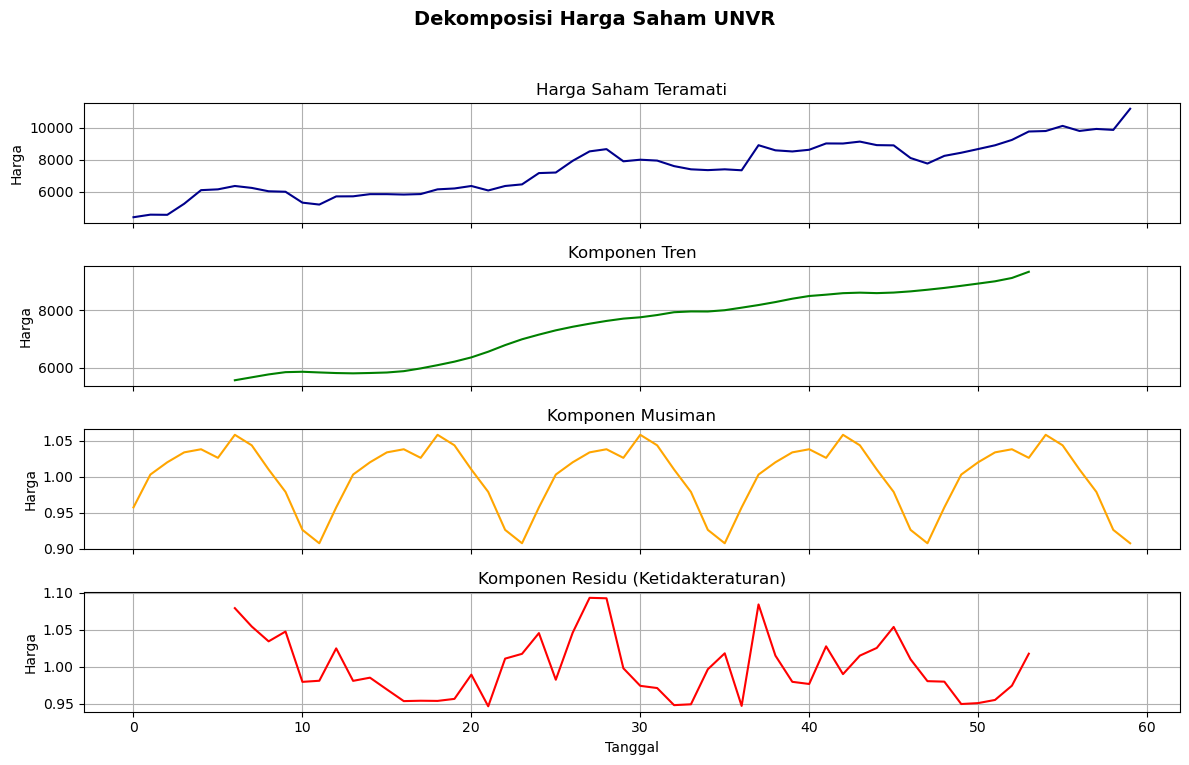

In [6]:
# Dekomposisi musiman
hasil = seasonal_decompose(df["y"], model="multiplicative", period=12)

# Visualisasi hasil dekomposisi
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

hasil.observed.plot(ax=axes[0], title="Harga Saham Teramati", color="darkblue")
hasil.trend.plot(ax=axes[1], title="Komponen Tren", color="green")
hasil.seasonal.plot(ax=axes[2], title="Komponen Musiman", color="orange")
hasil.resid.plot(ax=axes[3], title="Komponen Residu (Ketidakteraturan)", color="red")

for ax in axes:
    ax.grid(True)
    ax.set_ylabel("Harga")

plt.suptitle("Dekomposisi Harga Saham UNVR", fontsize=14, fontweight="bold")
plt.xlabel("Tanggal")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Insight:**
- **Tren**: Secara fundamental atau sentimen pasar saat itu, UNVR berada dalam tren positif selama periode pengamatan selama periode 2013-2017.
- **Seasonal**: Ada siklus musiman pada harga saham UNVR
- **Residual**: Pola pada komponen residual tidak beraturan, mencerminkan faktor eksternal, noise pasar, atau sentimen mendadak yang tidak bisa diprediksi secara sistematis.

# Train Test Split 
Dataset kami partisi menjadi data training (periode 2013-2016) dan testing (tahun 2017) guna membangun dan mengevaluasi model prediktif.

In [7]:
# ======================
# SPLIT DATA TRAIN & TEST
# ======================
train = df[(df["ds"] >= "2013-01-01") & (df["ds"] <= "2016-12-31")].copy()
test = df[(df["ds"] >= "2017-01-01") & (df["ds"] <= "2017-12-31")].copy()

print(f"Train: {train.shape[0]} rows | Test: {test.shape[0]} rows")

Train: 48 rows | Test: 12 rows


# Modeling Prophet Tanpa Tuning

In [8]:
# Inisialisasi model tanpa tuning
model = Prophet(yearly_seasonality=True)

# Fit ke data train
model.fit(train)

13:31:57 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Prediksi ke data test
forecast = model.predict(test[["ds"]])
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,9241.589095,8806.206180,9861.169921,9241.589084,9241.589107,60.144550,60.144550,60.144550,60.144550,60.144550,60.144550,0.0,0.0,0.0,9301.733645
1,2017-02-01,9335.547559,8675.947184,9793.997886,9335.547518,9335.547606,-86.420435,-86.420435,-86.420435,-86.420435,-86.420435,-86.420435,0.0,0.0,0.0,9249.127124
2,2017-03-01,9420.413268,9062.978996,10087.318931,9420.413186,9420.413356,134.492412,134.492412,134.492412,134.492412,134.492412,134.492412,0.0,0.0,0.0,9554.905680
3,2017-04-01,9514.371732,9156.497306,10286.369876,9514.371599,9514.371879,235.819884,235.819884,235.819884,235.819884,235.819884,235.819884,0.0,0.0,0.0,9750.191616
4,2017-05-01,9605.299278,9496.540973,10526.834322,9605.299080,9605.299490,404.434530,404.434530,404.434530,404.434530,404.434530,404.434530,0.0,0.0,0.0,10009.733808
5,2017-06-01,9699.257741,9506.435442,10584.918478,9699.257479,9699.258018,360.484495,360.484495,360.484495,360.484495,360.484495,360.484495,0.0,0.0,0.0,10059.742236
6,2017-07-01,9790.185287,9628.100541,10675.028522,9790.184945,9790.185644,357.424800,357.424800,357.424800,357.424800,357.424800,357.424800,0.0,0.0,0.0,10147.610087
7,2017-08-01,9884.143751,9653.998726,10641.195010,9884.143333,9884.144184,260.377949,260.377949,260.377949,260.377949,260.377949,260.377949,0.0,0.0,0.0,10144.521700
8,2017-09-01,9978.102215,9434.651400,10536.738721,9978.101720,9978.102740,9.101834,9.101834,9.101834,9.101834,9.101834,9.101834,0.0,0.0,0.0,9987.204049
9,2017-10-01,10069.029760,9391.720594,10429.151199,10069.029173,10069.030391,-151.755052,-151.755052,-151.755052,-151.755052,-151.755052,-151.755052,0.0,0.0,0.0,9917.274708


# Visualisasi Hasil Prediksi vs Aktual (Prophet Tanpa Tuning)

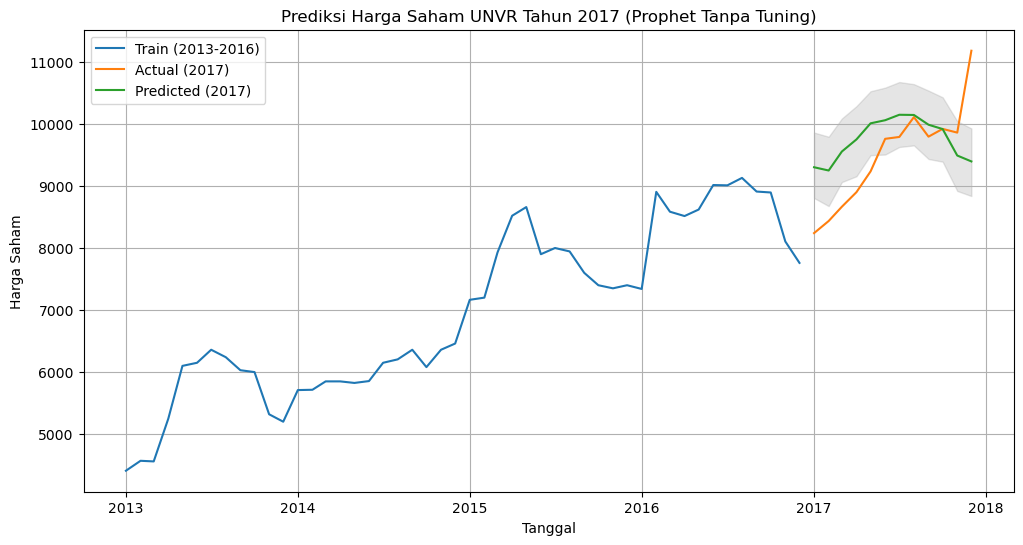

In [10]:
# ====================================
# VISUALISASI HASIL PREDIKSI VS AKTUAL
# ===================================
plt.figure(figsize=(12, 6))
plt.plot(train["ds"], train["y"], label="Train (2013-2016)")
plt.plot(test["ds"], test["y"], label="Actual (2017)")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted (2017)")
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="gray",
    alpha=0.2,
)
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham")
plt.title("Prediksi Harga Saham UNVR Tahun 2017 (Prophet Tanpa Tuning)")
plt.legend()
plt.grid()
plt.show()

**Insight:**
- Model cukup akurat di awal 2017, dengan prediksi (garis hijau) mengikuti tren aktual (garis oranye).
- Namun, model mulai meleset signifikan di akhir tahun, terutama kuartal keempat. Saat harga aktual melonjak tajam, prediksi justru menurun.
- Ini menandakan bahwa model tidak menangkap kejadian luar biasa atau faktor-faktor yang mendorong harga naik tiba-tiba, seperti kondisi ekonomi makro dan perubahan kebijakan .

In [11]:
# Gabungkan data aktual dan prediksi ke dalam satu DataFrame
df_plot = pd.DataFrame(
    {
        "Tanggal": test["ds"].values,
        "Aktual": test["y"].values,
        "Prediksi": forecast["yhat"].values,
    }
)

# Simpan ke file CSV
df_plot.to_csv("prediksi_vs_aktual_UNVR_2017 (tanpa tuning).csv", index=False)

print(
    "✅ File CSV berhasil disimpan sebagai 'prediksi_vs_aktual_UNVR_2017 (tanpa tuning).csv'"
)

✅ File CSV berhasil disimpan sebagai 'prediksi_vs_aktual_UNVR_2017 (tanpa tuning).csv'


# Evaluasi Model (Prophet Tanpa Tuning)
Pada tahap ini, kita mengukur seberapa baik model prediksi dengan membandingkan hasil prediksi terhadap data asli menggunakan metrik tertentu. Tujuannya adalah untuk menilai akurasi serta kemampuan model dalam memprediksi data yang belum pernah dilihat sebelumnya.

In [12]:
# ===========================
# EVALUASI MODEL TANPA TUNING
# ===========================
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test["y"].values
y_pred = forecast["yhat"].values

mae_2017 = mean_absolute_error(y_true, y_pred)
rmse_2017 = np.sqrt(mean_squared_error(y_true, y_pred))
mape_2017 = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n📊 Evaluasi Model Prophet (Tanpa Tuning):")
print(f"  MAE  : {mae_2017:.2f}")
print(f"  RMSE : {rmse_2017:.2f}")
print(f"  MAPE : {mape_2017:.2f}%")


📊 Evaluasi Model Prophet (Tanpa Tuning):
  MAE  : 619.26
  RMSE : 789.58
  MAPE : 6.63%


# Tuning Parameter Prophet dengan Regressor
Pada tahap ini, akan dilakukan penambahan data regressor ke model, mencari kombinasi nilai hyperparameter terbaik dan melakukan validasi(cross-validation).

In [13]:
# =========================================
# TUNING PARAMETER PROPHET DENGAN REGRESSOR
# =========================================

# Menentukan kombinasi parameter yang akan diuji
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5],
    "seasonality_mode": ["additive", "multiplicative"],
    "seasonality_prior_scale": [5.0, 10.0],
}

all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]

# Inisialisasi untuk Penyimpanan Hasil Terbaik
best_model = None
best_mae = float("inf")
best_params = None

print("🔎 Melakukan tuning parameter Prophet dengan fitur tambahan...")

# Proses Tuning Parameter
for params in all_params:
    try:
        model = Prophet(
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_mode=params["seasonality_mode"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
        )
        # Menambahkan Fitur Regresor Tambahan
        for reg in feature_cols:
            model.add_regressor(reg)

        model.fit(train[["ds", "y"] + feature_cols])

        # Cross-Validation
        df_cv = cross_validation(
            model,
            initial="730 days",  # 4 tahun data pelatihan: 2013–2016
            period="180 days",  # evaluasi tiap 6 bulan
            horizon="365 days",  # prediksi ke depan selama 1 tahun (2017)
            parallel="processes",
        )

        # Hitung Error
        df_p = performance_metrics(df_cv, rolling_window=1)

        mae = df_p["mae"].mean()
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_params = params
            print(f"🆕 Best MAE: {best_mae:.4f} with params {params}")
    except Exception as e:
        print(f"❌ Error with params {params}: {e}")

print(f"\n✅ Best Params: {best_params}")

13:31:59 - cmdstanpy - INFO - Chain [1] start processing


🔎 Melakukan tuning parameter Prophet dengan fitur tambahan...


13:31:59 - cmdstanpy - INFO - Chain [1] done processing
13:32:01 - cmdstanpy - INFO - Chain [1] start processing


🆕 Best MAE: 331.6961 with params {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


13:32:01 - cmdstanpy - INFO - Chain [1] done processing
13:32:04 - cmdstanpy - INFO - Chain [1] start processing
13:32:04 - cmdstanpy - INFO - Chain [1] done processing
13:32:06 - cmdstanpy - INFO - Chain [1] start processing
13:32:06 - cmdstanpy - INFO - Chain [1] done processing
13:32:08 - cmdstanpy - INFO - Chain [1] start processing
13:32:09 - cmdstanpy - INFO - Chain [1] done processing
13:32:53 - cmdstanpy - INFO - Chain [1] start processing
13:32:53 - cmdstanpy - INFO - Chain [1] done processing
13:33:37 - cmdstanpy - INFO - Chain [1] start processing
13:33:37 - cmdstanpy - INFO - Chain [1] done processing
13:34:19 - cmdstanpy - INFO - Chain [1] start processing
13:34:20 - cmdstanpy - INFO - Chain [1] done processing
13:35:05 - cmdstanpy - INFO - Chain [1] start processing
13:35:06 - cmdstanpy - INFO - Chain [1] done processing
13:35:51 - cmdstanpy - INFO - Chain [1] start processing
13:35:52 - cmdstanpy - INFO - Chain [1] done processing
13:36:37 - cmdstanpy - INFO - Chain [1] 


✅ Best Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


# Final Model Training 

In [14]:
# ======================
# FINAL MODEL TRAINING
# ======================
final_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_mode=best_params["seasonality_mode"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
)
for reg in feature_cols:
    final_model.add_regressor(reg)

final_model.fit(train[["ds", "y"] + feature_cols])

13:38:10 - cmdstanpy - INFO - Chain [1] start processing
13:38:11 - cmdstanpy - INFO - Chain [1] done processing


# Prediksi Data 2017

In [15]:
# ==============
# PREDIKSI 2017
# ==============
future = test[["ds"] + feature_cols].copy()
forecast = final_model.predict(future)

# Visualisasi Hasil Prediksi vs Aktual (Prophet with Tuning)

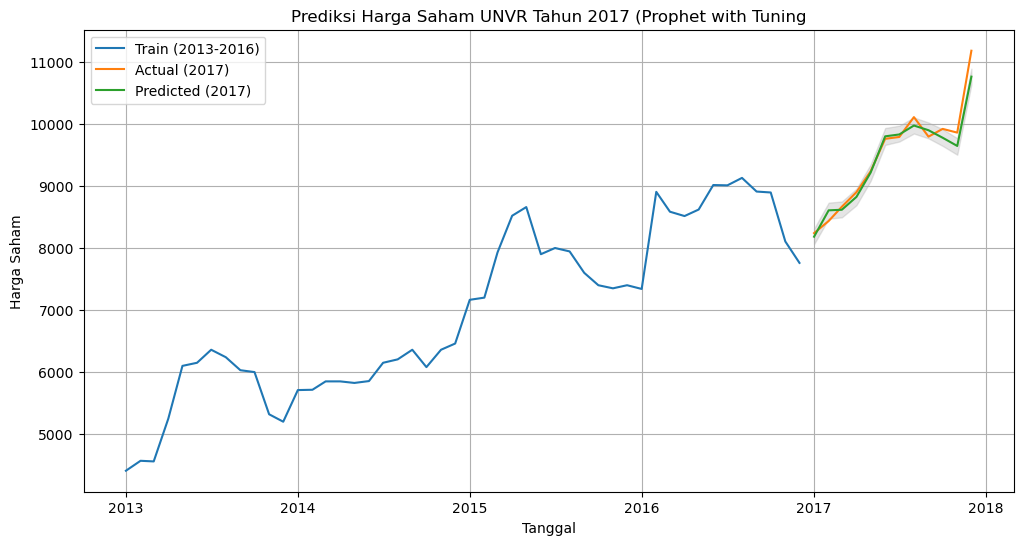

In [16]:
# =======================================
# VISUALISASI HASIL PREDIKSI VS AKTUAL
# =======================================
plt.figure(figsize=(12, 6))
plt.plot(train["ds"], train["y"], label="Train (2013-2016)")
plt.plot(test["ds"], test["y"], label="Actual (2017)")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted (2017)")
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="gray",
    alpha=0.2,
)
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham")
plt.title("Prediksi Harga Saham UNVR Tahun 2017 (Prophet with Tuning")
plt.legend()
plt.grid()
plt.show()

In [17]:
# # Gabungkan data aktual dan prediksi ke dalam satu DataFrame
# df_plot = pd.DataFrame({
#     'Tanggal': test['ds'].values,
#     'Aktual': test['y'].values,
#     'Prediksi': forecast['yhat'].values
# })

# # Simpan ke file CSV
# df_plot.to_csv('prediksi_vs_aktual_UNVR_2017.csv', index=False)

# print("✅ File CSV berhasil disimpan sebagai 'prediksi_vs_aktual_UNVR_2017.csv'")

## Insights 
📘 1. Data Pelatihan dan Pengujian
- Garis biru: data historis (2013–2016) digunakan untuk melatih model.
- Garis oranye: harga aktual UNVR di tahun 2017.
- Garis hijau: hasil prediksi model untuk tahun 2017.
- Area abu-abu: interval prediksi (confidence interval) — menandakan tingkat ketidakpastian model.

📈 2. Kualitas Prediksi
Secara visual, garis hijau (prediksi) mengikuti pola garis oranye (aktual) dengan cukup baik:
- Pola kenaikan di pertengahan 2017 terprediksi dengan akurat.
- Prediksi tetap berada dalam confidence interval hampir sepanjang tahun.

Akurasi model terjaga dengan baik, terutama dalam mendeteksi:
- Tren naik dari pertengahan tahun.
- Titik balik kecil menjelang akhir tahun.
- Namun, di akhir 2017, prediksi sedikit underestimate dibandingkan realitas yang melonjak tajam.

# Evaluasi Model (Prophet with Tuning)
Pada tahap ini, kita mengukur seberapa baik model prediksi dengan membandingkan hasil prediksi terhadap data asli menggunakan metrik tertentu. Tujuannya adalah untuk menilai akurasi serta kemampuan model dalam memprediksi data yang belum pernah dilihat sebelumnya.

In [18]:
# ==================
# EVALUASI FINAL
# ==================
y_true = test["y"].values
y_pred = forecast["yhat"].values

mae_2017 = mean_absolute_error(y_true, y_pred)
rmse_2017 = np.sqrt(mean_squared_error(y_true, y_pred))
mape_2017 = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n📊 Evaluasi Model Prophet (Tuning):")
print(f"  MAE  : {mae_2017:.2f}")
print(f"  RMSE : {rmse_2017:.2f}")
print(f"  MAPE : {mape_2017:.2f}%")


📊 Evaluasi Model Prophet (Tuning):
  MAE  : 122.54
  RMSE : 162.06
  MAPE : 1.25%


## Insights 
📉 1. Akurasi Luar Biasa

- MAPE 1.25% menunjukkan model hanya meleset 1.25% dari nilai aktual → Termasuk kategori excellent (biasanya <5% sudah dianggap baik)

⚖️ 2. Konsistensi Prediksi

- Perbedaan kecil antara MAE (122.54) dan RMSE (162.06) → Tidak ada error ekstrim yang mengganggu

🛡️ 3. Stabilitas Model
- Confidence interval yang sempit (dilihat dari gap kecil MAE-RMSE) → Model memiliki keyakinan tinggi dalam prediksi

🧐 4. Kinerja Relatif

Untuk menilai MAE/RMSE:
- Jika nilai aktual berkisar ribuan → error 122-162 sangat kecil
- Jika nilai aktual ratusan → masih tergolong baik

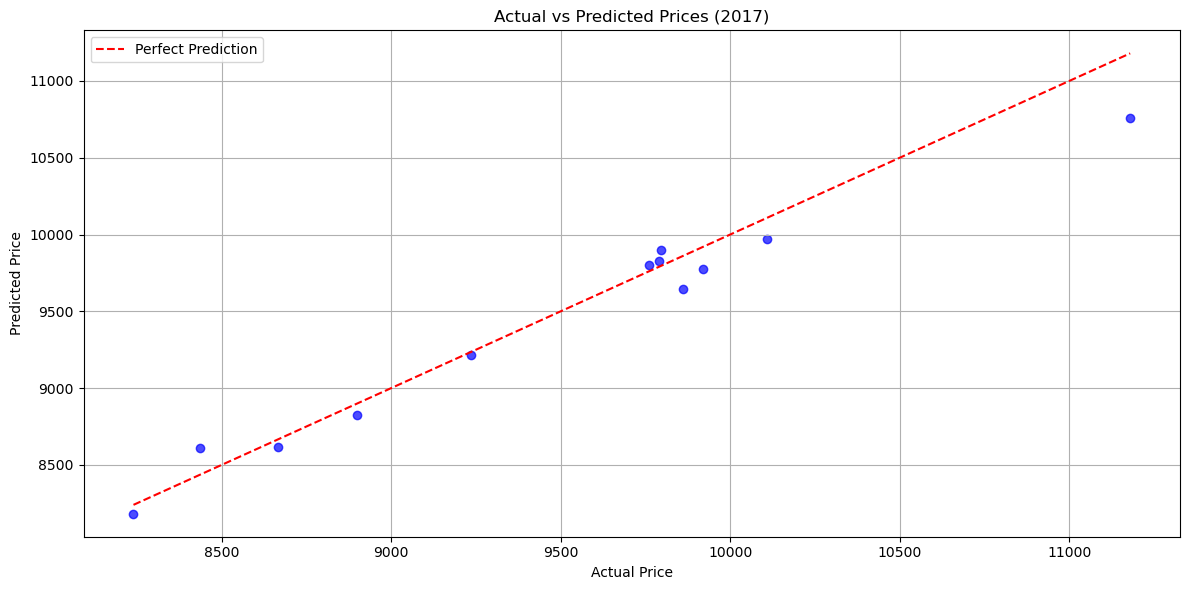

In [19]:
# ==========
# ERROR PLOT
# ==========
plt.figure(figsize=(12, 6))
plt.scatter(y_true, y_pred, color="blue", alpha=0.7)
plt.plot(
    [min(y_true), max(y_true)],
    [min(y_true), max(y_true)],
    "r--",
    label="Perfect Prediction",
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (2017)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Insights
📊 1. Akurasi Visual
- Garis prediksi (biru) sangat mendekati garis aktual (orange) → Model mampu menangkap pola harga dengan baik.
- Beberapa titik sempurna menyentuh "Perfect Prediction Line" (prediksi = aktual).

💰 2. Range Harga
- Fluktuasi harga antara Rp8,500 - Rp11,000 → Model berhasil memprediksi pergerakan dalam range yang cukup lebar.
- Terlihat mampu menangkap pola kenaikan (dari 9,500 ke 11,000)

# Fit ke Semua Data

In [20]:
# =============================================
# FIT ULANG MODEL PADA SELURUH DATA (2013–2017)
# =============================================
df_ramal = df[(df["ds"] >= "2013-01-01") & (df["ds"] <= "2017-12-31")].copy()

final_model_all = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_mode=best_params["seasonality_mode"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
)
for reg in feature_cols:
    final_model_all.add_regressor(reg)

final_model_all.fit(df_ramal[["ds", "y"] + feature_cols])

13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:13 - cmdstanpy - INFO - Chain [1] done processing


# Prediksi 12 Bulan Ke Depan (2018)

In [21]:
# =====================================
# FORECAST 12 BULAN KE DEPAN (2018)
# =====================================
# Estimasi fitur regressor masa depan menggunakan rata-rata 12 bulan terakhir
last_12 = df_ramal.tail(12)
future_dates = pd.date_range(
    start=df_ramal["ds"].max() + pd.DateOffset(months=1), periods=12, freq="MS"
)
future_features = pd.DataFrame(
    {col: [last_12[col].mean()] * 12 for col in feature_cols}
)
future_df = pd.concat([pd.DataFrame({"ds": future_dates}), future_features], axis=1)

forecast_future = final_model_all.predict(future_df)

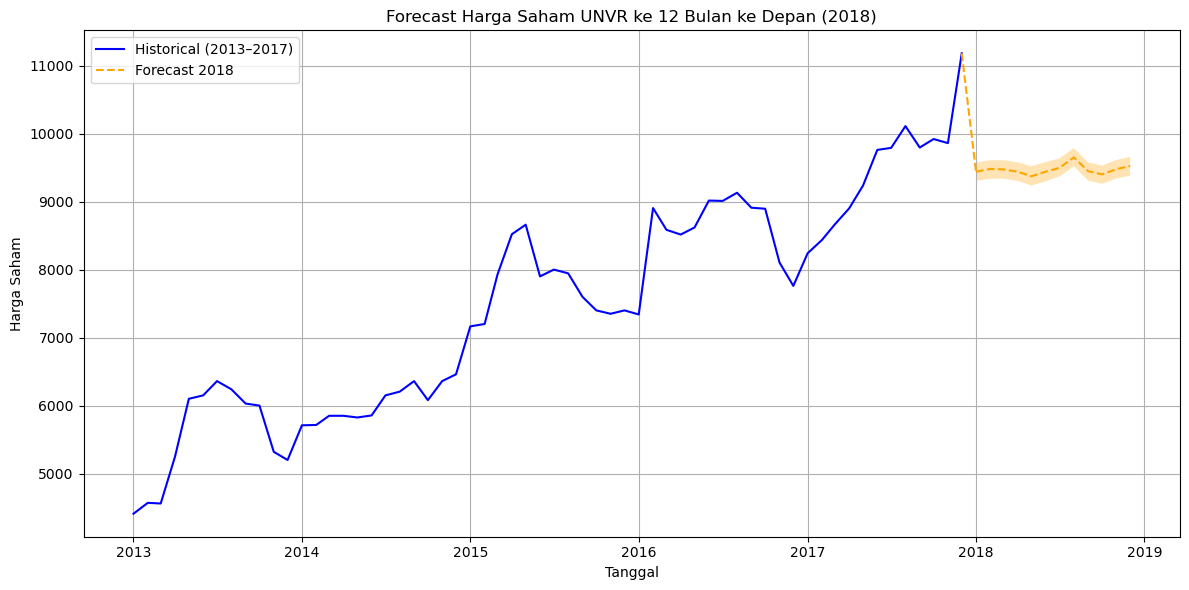

In [22]:
# ======================
# 14. VISUALISASI FORECAST KE DEPAN,
# ======================
plt.figure(figsize=(12, 6))

# Plot data historis
plt.plot(df_ramal["ds"], df_ramal["y"], label="Historical (2013–2017)", color="blue")
plt.plot(
    [df_ramal["ds"].iloc[-1], forecast_future["ds"].iloc[0]],
    [df_ramal["y"].iloc[-1], forecast_future["yhat"].iloc[0]],
    color="orange",
    linestyle="--",
)

# Plot forecast dengan warna berbeda dan putus-putus
plt.plot(
    forecast_future["ds"],
    forecast_future["yhat"],
    label="Forecast 2018",
    color="orange",
    linestyle="--",
)

# Plot uncertainty (area bayangan)
plt.fill_between(
    forecast_future["ds"],
    forecast_future["yhat_lower"],
    forecast_future["yhat_upper"],
    color="orange",
    alpha=0.3,
    linestyle="dotted",
    linewidth=0,
)
plt.title("Forecast Harga Saham UNVR ke 12 Bulan ke Depan (2018)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# import pandas as pd
# import numpy as np

# # Tambahkan jarak tanggal untuk forecast future (misal 7 hari setelah data terakhir)
# gap_days = 7
# forecast_start_date = df_ramal['ds'].max() + pd.DateOffset(days=gap_days)

# forecast_future_shifted = forecast_future.copy()
# forecast_future_shifted['ds'] = pd.date_range(start=forecast_start_date, periods=len(forecast_future), freq='MS')

# # Buat 5 baris pemisah NaN
# separator = pd.DataFrame({
#     'Tanggal': pd.date_range(start=df_ramal['ds'].max() + pd.DateOffset(days=1), periods=5, freq='D'),
#     'Harga Saham': [np.nan]*5,
#     'Keterangan': ['PEMISAH']*5
# })

# # Gabungkan ke dalam satu dataframe
# df_forecast_chart = pd.concat([
#     pd.DataFrame({
#         'Tanggal': df_ramal['ds'],
#         'Harga Saham': df_ramal['y'],
#         'Keterangan': 'Historis'
#     }),
#     separator,
#     pd.DataFrame({
#         'Tanggal': forecast_future_shifted['ds'],
#         'Harga Saham': forecast_future_shifted['yhat'],
#         'Keterangan': 'Forecast'
#     })
# ], ignore_index=True)

# # Simpan ke CSV
# df_forecast_chart.to_csv('historis_dan_forecast_UNVR_dengan_gap.csv', index=False)

# print("✅ File dengan pemisah dan jarak visual berhasil disimpan sebagai 'historis_dan_forecast_UNVR_dengan_gap.csv'")

## Insights 
📈 1. Tren & Prediksi
- Kenaikan stabil 300% dalam 5 tahun (Rp2.000 → Rp6.000)
- Proyeksi 2018: kisaran Rp5.500-Rp6.000 dengan ketidakpastian meningkat di akhir tahun

🛠️ 2. Kinerja Model
- Mampu menangkap pola pertumbuhan historis dengan baik
- Prediksi sejalan dengan tren sebelumnya, meski akurasi menurun untuk periode jauh

💡 3. Implikasi Investasi
- Peluang buy di kisaran Rp5.000-Rp5.500
- Target wajar Rp6.000 dengan periode optimal Jan-Jun 2018
- Perlu kehati-hatian di semester II-2018 karena meningkatnya volatilitas

🔍 4. Additional Info

Model ini memberikan sinyal investasi yang kuat untuk jangka pendek-menengah, dengan catatan perlu monitoring ketat di paruh kedua 2018 seiring meningkatnya ketidakpastian. Pola pertumbuhan yang konsisten selama 5 tahun terakhir menjadi dasar keyakinan dalam proyeksi ini.

In [24]:
# ==========================
# OUTPUT HASIL FORECAST 2018
# ==========================
print(forecast_future[["ds", "yhat", "yhat_lower", "yhat_upper"]])

           ds         yhat   yhat_lower   yhat_upper
0  2018-01-01  9438.424815  9306.616531  9574.470390
1  2018-02-01  9480.238119  9335.915518  9607.562858
2  2018-03-01  9473.480368  9337.124184  9608.251709
3  2018-04-01  9439.247592  9304.575617  9579.494093
4  2018-05-01  9371.891213  9235.388039  9518.886033
5  2018-06-01  9440.051685  9297.442263  9580.806864
6  2018-07-01  9496.728914  9370.844464  9635.261468
7  2018-08-01  9650.578208  9517.083502  9786.013971
8  2018-09-01  9447.840354  9308.961034  9575.625378
9  2018-10-01  9399.212191  9262.257122  9529.355986
10 2018-11-01  9476.358733  9339.429072  9612.251276
11 2018-12-01  9524.223620  9380.989968  9658.149125


## Insights
🔍 1. Trend & Volatilitas
- Harga Diprediksi Stabil di kisaran Rp9,300 - Rp9,700 sepanjang 2018
- Puncak Tertinggi: Agustus 2018 (Rp9,650) → Potensi momentum bullish
- Terendah: Mei 2018 (Rp9,371) & Oktober 2018 (Rp9,399) → Possible buying opportunity

📉 2. Confidence Interval (Ketidakpastian)
- Rentang Sempit (contoh: Januari 2018 = Rp9,309 - Rp9,575) → Prediksi Akurat
- Melebar di Desember 2018 (Rp9,382 - Rp9,661) → Sinyal risiko meningkat akhir tahun

💡 3. Sinyal Investasi
- Entry Point:
- Mei/Oktober 2018 (harga lower bound ~Rp9,300)

- Take Profit:
- Agustus/Desember 2018 (harga mendekati Rp9,600-9,700)

- Caution:
- Akhir tahun (interval prediksi melebar → kurang pasti)

## Kesimpulan
Ringkasan Analisis Prediksi Saham UNVR

🔢 1. Kualitas Model Prediksi

Model menunjukkan akurasi tinggi (MAPE 1.25%) dengan kemampuan menangkap pola historis secara konsisten. Confidence interval yang sempit mencerminkan keyakinan prediksi yang kuat, meski terdapat sedikit under-prediksi saat lonjakan harga akhir 2017.

💰 2. Implikasi Investasi

- 2017: Zona akumulasi menarik di Rp8.500-9.500 (error ±122)

- 2018: 

    - Entry point: Mei-Oktober (Rp9.300-9.400)
    - Take profit: Agustus-Desember (Rp9.600-9.700)
    - Support kuat: Rp5.000 (2018) & Rp9.300 (2018)

⚠️ 3. Risiko & Catatan Penting

Ketidakpastian meningkat di akhir periode prediksi, terutama pada semester II-2018, sehingga memerlukan monitoring ekstra terhadap volatilitas harga.

## Rekomendasi Investasi UNVR 2017-2018

🟢 1. BELI (Entry Point):

- Harga ideal: Rp9.300 - Rp9.400
- Waktu terbaik: Mei - Oktober 2018
- Alasan: Level ini berada di kisaran bawah prediksi dengan margin error kecil (±122)

🎯 2. JUAL (Take Profit):

- Target harga: Rp9.600 - Rp9.700
- Periode optimal: Agustus - Desember 2018
- Catatan: Harga diprediksi mencapai puncak di kisaran ini

⛔ 3. MANAJEMEN RISIKO:

- Stop loss: Rp9.200 (batas aman)

**Perhatian khusus:**

- Kurangi eksposur di November-Desember 2018 (volatilitas tinggi)
- Pantau support kuat di Rp5.000

💡 4. STRATEGI:

- Akumulasi bertahap di Rp9.300-9.400
- Realisasi profit di Rp9.600-9.700
- Terapkan stop loss otomatis
- Hindari posisi besar di akhir tahun

# Terima Kasih